In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
import keras_tuner
from sklearn.model_selection import train_test_split

In [2]:
seed_value = 4 # 4
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
SAVE_FIGURES = True

In [3]:
data = pd.read_csv('./TESTclean.csv').sample(frac=1)
spectra = np.array(data.iloc[:, 1:])
redshifts = np.array(data.iloc[:, 0])

In [4]:
# standard_scaler = StandardScaler()
# spectra = standard_scaler.fit_transform(spectra)
# quantile_transformer = QuantileTransformer(random_state=seed_value)
# spectra = quantile_transformer.fit_transform(spectra)
min_max_scaler = MinMaxScaler()
spectra = min_max_scaler.fit_transform(spectra)

spectra_train, spectra_test, redshift_train, redshift_test = train_test_split(spectra, redshifts, test_size=0.1, random_state=seed_value) # 0.9

In [5]:
# conv 256 5
# conv 256 5
# conv 128 3
# conv 64 2
# dense 256
# dense 256
# dense 128
# dense 64

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(186, 1)),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model.compile(optimizer='adamax', loss='huber', metrics=['mean_absolute_error']) # adamax, huber

In [6]:
batch_size = 16 # 16
epochs = 20 # 30
validation_split = 0.3 # 0.3
history = model.fit(spectra_train, redshift_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
# history = model.fit(spectra_train, redshift_train, epochs=epochs, batch_size=batch_size, validation_data=(spectra_test, redshift_test))

Epoch 1/20
20491/20491 [==============================] - 220s 11ms/step - loss: 6.7923e-04 - mean_absolute_error: 0.0260 - val_loss: 5.7935e-04 - val_mean_absolute_error: 0.0237
Epoch 2/20
20491/20491 [==============================] - 213s 10ms/step - loss: 5.7933e-04 - mean_absolute_error: 0.0237 - val_loss: 5.5832e-04 - val_mean_absolute_error: 0.0233
Epoch 3/20
20491/20491 [==============================] - 219s 11ms/step - loss: 5.5169e-04 - mean_absolute_error: 0.0230 - val_loss: 5.4095e-04 - val_mean_absolute_error: 0.0228
Epoch 4/20
20491/20491 [==============================] - 217s 11ms/step - loss: 5.3560e-04 - mean_absolute_error: 0.0227 - val_loss: 5.2418e-04 - val_mean_absolute_error: 0.0225
Epoch 5/20
20491/20491 [==============================] - 217s 11ms/step - loss: 5.2422e-04 - mean_absolute_error: 0.0225 - val_loss: 5.3919e-04 - val_mean_absolute_error: 0.0229
Epoch 6/20
20491/20491 [==============================] - 218s 11ms/step - loss: 5.1849e-04 - mean_absolu

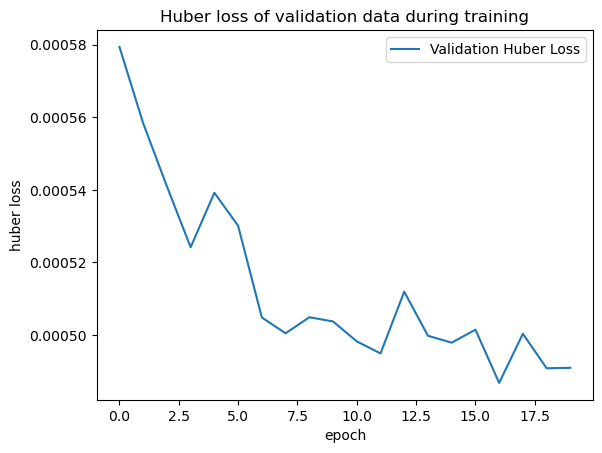

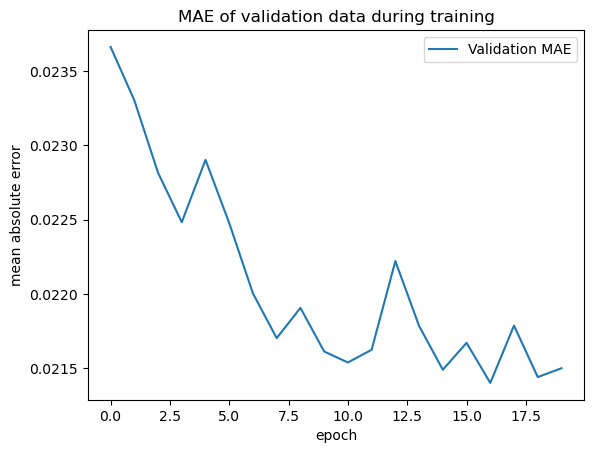

In [7]:
EPOCH_SKIP_PCT = 0

pd.DataFrame(history.history['val_loss'][int(EPOCH_SKIP_PCT * epochs):]).plot()
plt.legend(['Validation Huber Loss'])
plt.xlabel('epoch')
plt.ylabel('huber loss')
plt.title('Huber loss of validation data during training')
if SAVE_FIGURES: plt.savefig('./graphs/mse_val.png')

pd.DataFrame(history.history['val_mean_absolute_error'][int(EPOCH_SKIP_PCT * epochs):]).plot()
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.title('MAE of validation data during training')
plt.legend(['Validation MAE'])
if SAVE_FIGURES: plt.savefig('./graphs/mae_val.png')

plt.show()

In [14]:
# spectra_to_predict = spectra_val
# redshifts_true = redshift_val
# spectra_to_predict = spectra
# redshifts_true = redshifts
spectra_to_predict = spectra_test
redshifts_true = redshift_test

redshift_predicted = model.predict(spectra_to_predict, batch_size=1000)
redshift_predicted = np.reshape(redshift_predicted, (spectra_to_predict.shape[0],))

53/53 [==============================] - 3s 54ms/step


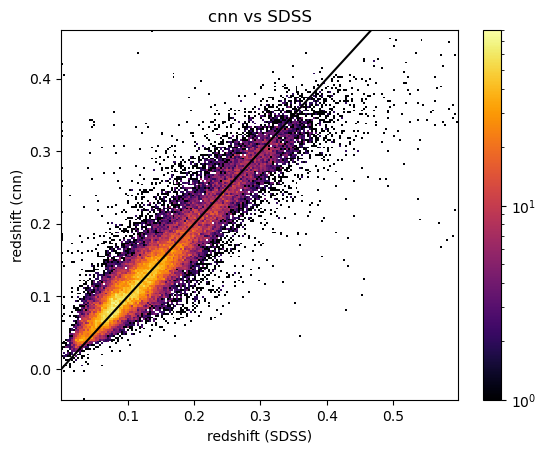

In [15]:
BINS = 200
CMAP = 'inferno'

plt.figure()
plt.hist2d(redshifts_true, redshift_predicted, bins=BINS, norm=matplotlib.colors.LogNorm(), cmap=CMAP)
plt.plot([0, 0.6], [0, 0.6], '-', c='black')
plt.xlabel('redshift (SDSS)')
plt.ylabel('redshift (cnn)')
plt.colorbar()
plt.title("cnn vs SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist2d.png')

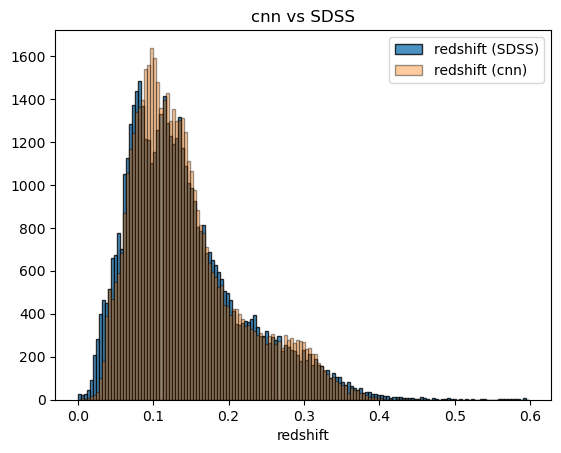

In [16]:
HIST_BIN_SCALE = 150

plt.figure()
plt.hist(redshifts_true, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.8, label='redshift (SDSS)')
plt.hist(redshift_predicted, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.4, label='redshift (cnn)')
plt.xlabel('redshift')
plt.title("cnn vs SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist.png')

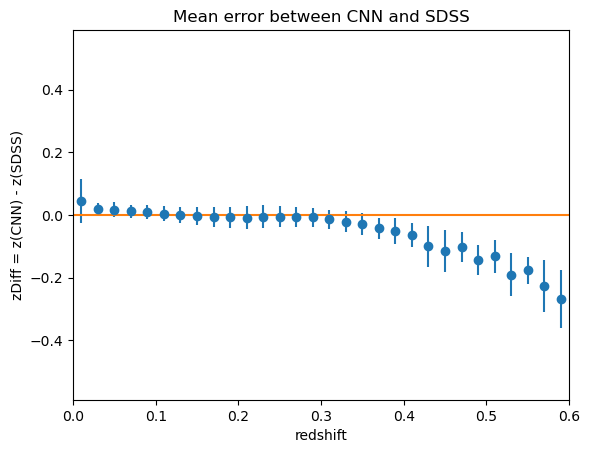

In [17]:
BIN_SIZE = 0.02

absolute_error = redshift_predicted - redshifts_true
bins = np.arange(0, max(redshifts_true) + BIN_SIZE, BIN_SIZE)
bin_indices = np.digitize(redshifts_true, bins)
mean_errors = [np.mean(absolute_error[bin_indices == i]) for i in range(1, len(bins))]
std_errors = [np.std(absolute_error[bin_indices == i]) for i in range(1, len(bins))]

bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure()
plt.errorbar(bin_centers, mean_errors, yerr=std_errors, fmt='o')
plt.plot([0, 0.6], [0, 0])
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.xlim([0, 0.6])
plt.title(f"Mean error between CNN and SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae_errorbar.png')

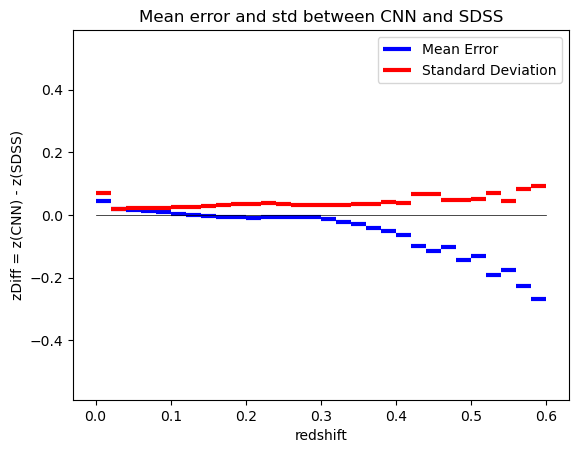

In [18]:
plt.figure()
plt.hlines(mean_errors, bins[:-1], bins[1:], colors=['blue'], linewidth=3.0, label='Mean Error')
plt.hlines(std_errors, bins[:-1], bins[1:], colors=['red'], linewidth=3.0, label='Standard Deviation')
plt.plot([0, 0.6], [0, 0], c='black', linewidth=0.5)
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.title(f"Mean error and std between CNN and SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae.png')